In [11]:
nodes_data = {}
edges_data = {}
times_data = {}

# Boruvka's Algorithm on the 5

## soc-sign-bitcoinalpha


*   3,783 nodes
*   24,186 edges



In [ ]:
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import os
import subprocess # For running external commands like ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter # Explicitly import FuncAnimation and FFMpegWriter

# --- 1. Define the DisjointSetUnion Class (Crucial for Boruvka's) ---
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n  # Used for union by rank optimization
        self.num_components = n # Tracks the number of disjoint sets

    def find(self, i):
        """Finds the representative (root) of the set containing element i, with path compression."""
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i]) # Path compression
        return self.parent[i]

    def union(self, i, j):
        """Unites the sets containing elements i and j, with union by rank."""
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            # Attach smaller rank tree under root of higher rank tree
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            self.num_components -= 1 # One less component after successful union
            return True  # Indicates a successful union (components merged)
        return False # Indicates they were already in the same set


# --- 2. Define your Graph/Network Class ---
class GraphAnalyzer:
    def __init__(self, df):
        """
        Initializes the GraphAnalyzer with a DataFrame containing graph data.
        :param df: Pandas DataFrame with 'source', 'target', and 'weight' columns.
        """
        self.df = df
        self.G = self._build_networkx_graph()
        self.node_to_idx = self._create_node_to_index_map()

    def _build_networkx_graph(self):
        """
        Builds a NetworkX graph from the DataFrame.
        Assumes 'source', 'target', and 'weight' columns.
        """
        G = nx.Graph() # Use nx.Graph for an undirected graph (MST is for undirected)
        for _, row in self.df.iterrows():
            try:
                weight = float(row['weight'])
            except ValueError:
                print(f"Warning: Non-numeric weight found for edge ({row['source']}, {row['target']}). Using weight 1.0.")
                weight = 1.0
            G.add_edge(row['source'], row['target'], weight=weight)
        return G

    def _create_node_to_index_map(self):
        """
        Creates a mapping from NetworkX node identifiers to 0-based integer indices
        for use with the DisjointSetUnion.
        """
        unique_nodes = sorted(self.G.nodes())
        return {node: idx for idx, node in enumerate(unique_nodes)}

    # --- Boruvka's MST Algorithm (MODIFIED to collect edges for `create_animation`) ---
    def boruvka_mst(self, animate=False, video_output_name=None):
        """
        Implements Borůvka's algorithm to find the Minimum Spanning Tree.
        Includes optional animation that uses the provided create_animation function.
        """
        start_time = time.time()

        n = len(self.G.nodes())
        if n == 0:
            return [], 0, 0, [0], [0], [0]

        dsu = DisjointSetUnion(n)
        mst_edges_list = [] # Renamed to avoid conflict with nx.Graph.edges()
        mst_cost = 0.0

        cost_evolution = [0.0]
        edges_count_evolution = [0]
        components_count_evolution = [n]

        # --- Store MST edges collected during the algorithm for animation ---
        # Boruvka's doesn't strictly build by increasing global weight,
        # but this list will store edges added to the MST.
        # This list will be used by create_animation, which will sort them by weight
        # to simulate a clear building process.
        edges_for_animation = []

        while dsu.num_components > 1:
            component_min_edge = {}

            if not self.G.edges():
                print("Warning: No edges in the graph, cannot form MST.")
                break

            for u_node, v_node, edge_attrs in self.G.edges(data=True):
                weight = edge_attrs['weight']

                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                comp_u_root = dsu.find(u_idx)
                comp_v_root = dsu.find(v_idx)

                if comp_u_root != comp_v_root:
                    if comp_u_root not in component_min_edge or float(weight) < component_min_edge[comp_u_root][0]:
                        component_min_edge[comp_u_root] = (float(weight), u_node, v_node)
                    if comp_v_root not in component_min_edge or float(weight) < component_min_edge[comp_v_root][0]:
                        component_min_edge[comp_v_root] = (float(weight), u_node, v_node)

            if not component_min_edge and dsu.num_components > 1:
                print("Warning: No edges found to connect remaining components. Graph may be disconnected.")
                break

            edges_added_in_phase = False
            # Sort edges for deterministic processing within a phase
            sorted_min_edges = sorted(component_min_edge.values(), key=lambda x: x[0])

            for weight, u_node, v_node in sorted_min_edges:
                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                if dsu.union(u_idx, v_idx):
                    mst_edges_list.append((u_node, v_node, weight))
                    mst_cost += weight
                    edges_added_in_phase = True

                    # Add edge to the list for animation
                    edges_for_animation.append((u_node, v_node, {'weight': weight}))

                    cost_evolution.append(mst_cost)
                    edges_count_evolution.append(len(mst_edges_list))
                    components_count_evolution.append(dsu.num_components)

            if not edges_added_in_phase and dsu.num_components > 1:
                print("Warning: Boruvka's algorithm made no progress in a phase but components remain. This indicates a disconnected graph.")
                break

        execution_time = time.time() - start_time

        if animate:
            print(f"\nGenerating MST animation...")
            if not video_output_name:
                video_output_name = "boruvka_mst_animation" # Default name if not provided

            # Construct the MST graph from the collected edges (sorted by weight in create_animation)
            mst_graph_for_animation = nx.Graph()
            # Add all edges collected during the algorithm run to this MST graph
            for u, v, weight_dict in edges_for_animation:
                mst_graph_for_animation.add_edge(u, v, weight=weight_dict['weight'])

            # Call the new animation function
            create_animation(self.G, mst_graph_for_animation, video_output_name)
            print(f"MST animation '{video_output_name}.mp4' created.")

        print(f"\n--- Boruvka's MST Results ---")
        print(f"MST Total Cost: {mst_cost:.4f}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print(f"Number of Edges in MST: {len(mst_edges_list)}")
        print(f"Final Number of Components: {dsu.num_components}")

        return mst_edges_list, mst_cost, execution_time, cost_evolution, edges_count_evolution, components_count_evolution

# --- NEW/MODIFIED ANIMATION FUNCTION (`create_animation` based on requirements) ---
def create_animation(G, mst, name):
    """
    Creates an animation of the MST being built, starting with a blank canvas
    and adding 100 MST edges at a time. Only nodes connected by current MST edges
    are shown (lit up).

    Args:
        G (nx.Graph): The original graph (used for node positions).
        mst (nx.Graph): The Minimum Spanning Tree graph.
        name (str): The base name for the output video file (e.g., 'my_mst_animation').
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    # Calculate positions once for the entire original graph for consistency
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout

    # Get MST edges and sort by weight for animation.
    # This sorting ensures a consistent building visual (like Prim's/Kruskal's),
    # even if Boruvka's doesn't add edges strictly by global weight in every phase.
    mst_edges_sorted = list(mst.edges(data=True))
    mst_edges_sorted.sort(key=lambda x: x[2]['weight'])
    total_mst_edges = len(mst_edges_sorted)

    # --- Frame calculation: add 100 edges at a time ---
    frames_edge_counts = []
    current_count = 0
    while current_count < total_mst_edges:
        frames_edge_counts.append(current_count)
        current_count += 100
    frames_edge_counts.append(total_mst_edges) # Ensure the last frame shows all edges

    # Animation function
    def update(frame_idx):
        ax.clear() # Start each frame with a blank canvas

        num_edges_to_show = frames_edge_counts[frame_idx]
        current_mst_edges_data = mst_edges_sorted[:num_edges_to_show]

        # Collect all unique nodes that are part of the current MST edges displayed
        nodes_in_current_mst = set()
        for u, v, _ in current_mst_edges_data:
            nodes_in_current_mst.add(u)
            nodes_in_current_mst.add(v)

        # Draw only nodes that are part of the current MST edges (light up if used)
        if nodes_in_current_mst:
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes_in_current_mst),
                                   node_color='pink', node_size=60, ax=ax) # Increased node_size for visibility

        # Draw the current MST edges in 'midnightblue'
        if current_mst_edges_data:
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(u, v) for u, v, _ in current_mst_edges_data],
                                   edge_color='midnightblue', width=2, ax=ax)

        # Calculate cumulative weight up to the current frame
        cumulative_weight = sum(edge[2]['weight'] for edge in current_mst_edges_data)

        # Update title to show exact edge count and total weight
        ax.set_title(f'MST Building - Edges: {num_edges_to_show}/{total_mst_edges}\nTotal Weight: {cumulative_weight:.2f}')
        ax.axis('off') # Keep axes off for a cleaner graph visualization
        return ax

    # Create animation with specified interval and frames
    # interval=2000 means 2 seconds per frame
    ani = FuncAnimation(fig, update, frames=len(frames_edge_counts), interval=2000, blit=False)

    # Save animation as video
    # fps=0.5 means 0.5 frames per second (1 frame every 2 seconds)
    writer = FFMpegWriter(fps=0.5, metadata=dict(artist='AI'), bitrate=1800)
    ani.save(f'{name}.mp4', writer=writer)

    plt.close(fig) # Close the figure to free memory


# --- Main Execution Block ---
if __name__ == "__main__":
    # Load the dataset
    try:
        data_df = pd.read_csv('soc-sign-bitcoinalpha_cleaned.csv')
    except FileNotFoundError:
        print("Error: 'soc-sign-bitcoinalpha_cleaned.csv' not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
        print("Creating a small dummy graph for demonstration.")
        data = {
            'source': [0, 0, 1, 1, 2, 3],
            'target': [1, 2, 2, 3, 3, 4],
            'weight': [10, 15, 20, 25, 30, 5]
        }
        data_df = pd.DataFrame(data)

    # Instantiate the GraphAnalyzer
    analyzer = GraphAnalyzer(data_df)

    print("Running Boruvka's MST algorithm...")

    # --- Call boruvka_mst with animation settings ---
    output_dir = 'boruvka_BITCOINALPHA_video_output'
    os.makedirs(output_dir, exist_ok=True)
    video_base_name = os.path.join(output_dir, 'mst_BITCOINALPHA_animation') # Pass base name without .mp4

    results = analyzer.boruvka_mst(
        animate=True,
        video_output_name=video_base_name # Pass the base name for the video file
    )

    mst_edges, mst_cost, exec_time, cost_evol, edges_evol, components_evol = results

    # Now that exec_time, nodes_data, edges_data, and times_data are defined,
    # these lines will work correctly.
    nodes_data['bitcoinalpha'] = len(analyzer.G.nodes())
    edges_data['bitcoinalpha'] = len(analyzer.G.edges())
    times_data['bitcoinalpha'] = exec_time


    print(f"\nAlgorithm completed. Total execution time (from returned value): {exec_time:.4f} seconds")

    # Example of how you might plot the evolution data (uncomment to run)
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(cost_evol, marker='o', linestyle='-', label='MST Cost')
    # plt.plot(edges_evol, marker='x', linestyle='--', label='Edges in MST')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Value')
    # plt.title('MST Cost and Edges Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(components_evol, marker='s', linestyle='-', color='red', label='Number of Components')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Count')
    # plt.title('Number of Components Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

Running Boruvka's MST algorithm...

Generating MST animation...
MST animation 'boruvka_BITCOINALPHA_video_output/mst_BITCOINALPHA_animation.mp4' created.

--- Boruvka's MST Results ---
MST Total Cost: -1244.0000
Execution Time: 0.0983 seconds
Number of Edges in MST: 3778
Final Number of Components: 5

Algorithm completed. Total execution time (from returned value): 0.0983 seconds


## soc-sign-bitcoinotc

* 5,881 nodes
* 35,592 edges

In [ ]:
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import os
import subprocess # For running external commands like ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter # Explicitly import FuncAnimation and FFMpegWriter

# --- 1. Define the DisjointSetUnion Class (Crucial for Boruvka's) ---
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n  # Used for union by rank optimization
        self.num_components = n # Tracks the number of disjoint sets

    def find(self, i):
        """Finds the representative (root) of the set containing element i, with path compression."""
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i]) # Path compression
        return self.parent[i]

    def union(self, i, j):
        """Unites the sets containing elements i and j, with union by rank."""
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            # Attach smaller rank tree under root of higher rank tree
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            self.num_components -= 1 # One less component after successful union
            return True  # Indicates a successful union (components merged)
        return False # Indicates they were already in the same set


# --- 2. Define your Graph/Network Class ---
class GraphAnalyzer:
    def __init__(self, df):
        """
        Initializes the GraphAnalyzer with a DataFrame containing graph data.
        :param df: Pandas DataFrame with 'source', 'target', and 'weight' columns.
        """
        self.df = df
        self.G = self._build_networkx_graph()
        self.node_to_idx = self._create_node_to_index_map()

    def _build_networkx_graph(self):
        """
        Builds a NetworkX graph from the DataFrame.
        Assumes 'source', 'target', and 'weight' columns.
        """
        G = nx.Graph() # Use nx.Graph for an undirected graph (MST is for undirected)
        for _, row in self.df.iterrows():
            try:
                weight = float(row['weight'])
            except ValueError:
                print(f"Warning: Non-numeric weight found for edge ({row['source']}, {row['target']}). Using weight 1.0.")
                weight = 1.0
            G.add_edge(row['source'], row['target'], weight=weight)
        return G

    def _create_node_to_index_map(self):
        """
        Creates a mapping from NetworkX node identifiers to 0-based integer indices
        for use with the DisjointSetUnion.
        """
        unique_nodes = sorted(self.G.nodes())
        return {node: idx for idx, node in enumerate(unique_nodes)}

    # --- Boruvka's MST Algorithm (MODIFIED to collect edges for `create_animation`) ---
    def boruvka_mst(self, animate=False, video_output_name=None):
        """
        Implements Borůvka's algorithm to find the Minimum Spanning Tree.
        Includes optional animation that uses the provided create_animation function.
        """
        start_time = time.time()

        n = len(self.G.nodes())
        if n == 0:
            return [], 0, 0, [0], [0], [0]

        dsu = DisjointSetUnion(n)
        mst_edges_list = [] # Renamed to avoid conflict with nx.Graph.edges()
        mst_cost = 0.0

        cost_evolution = [0.0]
        edges_count_evolution = [0]
        components_count_evolution = [n]

        # --- Store MST edges collected during the algorithm for animation ---
        # Boruvka's doesn't strictly build by increasing global weight,
        # but this list will store edges added to the MST.
        # This list will be used by create_animation, which will sort them by weight
        # to simulate a clear building process.
        edges_for_animation = []

        while dsu.num_components > 1:
            component_min_edge = {}

            if not self.G.edges():
                print("Warning: No edges in the graph, cannot form MST.")
                break

            for u_node, v_node, edge_attrs in self.G.edges(data=True):
                weight = edge_attrs['weight']

                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                comp_u_root = dsu.find(u_idx)
                comp_v_root = dsu.find(v_idx)

                if comp_u_root != comp_v_root:
                    if comp_u_root not in component_min_edge or float(weight) < component_min_edge[comp_u_root][0]:
                        component_min_edge[comp_u_root] = (float(weight), u_node, v_node)
                    if comp_v_root not in component_min_edge or float(weight) < component_min_edge[comp_v_root][0]:
                        component_min_edge[comp_v_root] = (float(weight), u_node, v_node)

            if not component_min_edge and dsu.num_components > 1:
                print("Warning: No edges found to connect remaining components. Graph may be disconnected.")
                break

            edges_added_in_phase = False
            # Sort edges for deterministic processing within a phase
            sorted_min_edges = sorted(component_min_edge.values(), key=lambda x: x[0])

            for weight, u_node, v_node in sorted_min_edges:
                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                if dsu.union(u_idx, v_idx):
                    mst_edges_list.append((u_node, v_node, weight))
                    mst_cost += weight
                    edges_added_in_phase = True

                    # Add edge to the list for animation
                    edges_for_animation.append((u_node, v_node, {'weight': weight}))

                    cost_evolution.append(mst_cost)
                    edges_count_evolution.append(len(mst_edges_list))
                    components_count_evolution.append(dsu.num_components)

            if not edges_added_in_phase and dsu.num_components > 1:
                print("Warning: Boruvka's algorithm made no progress in a phase but components remain. This indicates a disconnected graph.")
                break

        execution_time = time.time() - start_time

        if animate:
            print(f"\nGenerating MST animation...")
            if not video_output_name:
                video_output_name = "boruvka_mst_animation" # Default name if not provided

            # Construct the MST graph from the collected edges (sorted by weight in create_animation)
            mst_graph_for_animation = nx.Graph()
            # Add all edges collected during the algorithm run to this MST graph
            for u, v, weight_dict in edges_for_animation:
                mst_graph_for_animation.add_edge(u, v, weight=weight_dict['weight'])

            # Call the new animation function
            create_animation(self.G, mst_graph_for_animation, video_output_name)
            print(f"MST animation '{video_output_name}.mp4' created.")

        print(f"\n--- Boruvka's MST Results ---")
        print(f"MST Total Cost: {mst_cost:.4f}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print(f"Number of Edges in MST: {len(mst_edges_list)}")
        print(f"Final Number of Components: {dsu.num_components}")

        return mst_edges_list, mst_cost, execution_time, cost_evolution, edges_count_evolution, components_count_evolution

# --- NEW/MODIFIED ANIMATION FUNCTION (`create_animation` based on requirements) ---
def create_animation(G, mst, name):
    """
    Creates an animation of the MST being built, starting with a blank canvas
    and adding 100 MST edges at a time. Only nodes connected by current MST edges
    are shown (lit up).

    Args:
        G (nx.Graph): The original graph (used for node positions).
        mst (nx.Graph): The Minimum Spanning Tree graph.
        name (str): The base name for the output video file (e.g., 'my_mst_animation').
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    # Calculate positions once for the entire original graph for consistency
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout

    # Get MST edges and sort by weight for animation.
    # This sorting ensures a consistent building visual (like Prim's/Kruskal's),
    # even if Boruvka's doesn't add edges strictly by global weight in every phase.
    mst_edges_sorted = list(mst.edges(data=True))
    mst_edges_sorted.sort(key=lambda x: x[2]['weight'])
    total_mst_edges = len(mst_edges_sorted)

    # --- Frame calculation: add 100 edges at a time ---
    frames_edge_counts = []
    current_count = 0
    while current_count < total_mst_edges:
        frames_edge_counts.append(current_count)
        current_count += 100
    frames_edge_counts.append(total_mst_edges) # Ensure the last frame shows all edges

    # Animation function
    def update(frame_idx):
        ax.clear() # Start each frame with a blank canvas

        num_edges_to_show = frames_edge_counts[frame_idx]
        current_mst_edges_data = mst_edges_sorted[:num_edges_to_show]

        # Collect all unique nodes that are part of the current MST edges displayed
        nodes_in_current_mst = set()
        for u, v, _ in current_mst_edges_data:
            nodes_in_current_mst.add(u)
            nodes_in_current_mst.add(v)

        # Draw only nodes that are part of the current MST edges (light up if used)
        if nodes_in_current_mst:
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes_in_current_mst),
                                   node_color='pink', node_size=60, ax=ax) # Increased node_size for visibility

        # Draw the current MST edges in 'midnightblue'
        if current_mst_edges_data:
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(u, v) for u, v, _ in current_mst_edges_data],
                                   edge_color='midnightblue', width=2, ax=ax)

        # Calculate cumulative weight up to the current frame
        cumulative_weight = sum(edge[2]['weight'] for edge in current_mst_edges_data)

        # Update title to show exact edge count and total weight
        ax.set_title(f'MST Building - Edges: {num_edges_to_show}/{total_mst_edges}\nTotal Weight: {cumulative_weight:.2f}')
        ax.axis('off') # Keep axes off for a cleaner graph visualization
        return ax

    # Create animation with specified interval and frames
    # interval=2000 means 2 seconds per frame
    ani = FuncAnimation(fig, update, frames=len(frames_edge_counts), interval=2000, blit=False)

    # Save animation as video
    # fps=0.5 means 0.5 frames per second (1 frame every 2 seconds)
    writer = FFMpegWriter(fps=0.5, metadata=dict(artist='AI'), bitrate=1800)
    ani.save(f'{name}.mp4', writer=writer)

    plt.close(fig) # Close the figure to free memory


# --- Main Execution Block ---
if __name__ == "__main__":
    # Load the dataset
    try:
        data_df = pd.read_csv('soc-sign-bitcoinotc_cleaned.csv')
    except FileNotFoundError:
        print("Error: 'soc-sign-bitcoinotc_cleaned.csv' not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
        print("Creating a small dummy graph for demonstration.")
        data = {
            'source': [0, 0, 1, 1, 2, 3],
            'target': [1, 2, 2, 3, 3, 4],
            'weight': [10, 15, 20, 25, 30, 5]
        }
        data_df = pd.DataFrame(data)

    # Instantiate the GraphAnalyzer
    analyzer = GraphAnalyzer(data_df)

    print("Running Boruvka's MST algorithm...")

    # --- Call boruvka_mst with animation settings ---
    output_dir = 'boruvka_BITCOINOTC_video_output'
    os.makedirs(output_dir, exist_ok=True)
    video_base_name = os.path.join(output_dir, 'mst_BITCOINOTC_animation') # Pass base name without .mp4

    results = analyzer.boruvka_mst(
        animate=True,
        video_output_name=video_base_name # Pass the base name for the video file
    )

    mst_edges, mst_cost, exec_time, cost_evol, edges_evol, components_evol = results

    # Now that exec_time, nodes_data, edges_data, and times_data are defined,
    # these lines will work correctly.
    nodes_data['bitcoinotc'] = len(analyzer.G.nodes())
    edges_data['bitcoinotc'] = len(analyzer.G.edges())
    times_data['bitcoinotc'] = exec_time


    print(f"\nAlgorithm completed. Total execution time (from returned value): {exec_time:.4f} seconds")

    # Example of how you might plot the evolution data (uncomment to run)
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(cost_evol, marker='o', linestyle='-', label='MST Cost')
    # plt.plot(edges_evol, marker='x', linestyle='--', label='Edges in MST')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Value')
    # plt.title('MST Cost and Edges Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(components_evol, marker='s', linestyle='-', color='red', label='Number of Components')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Count')
    # plt.title('Number of Components Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

Running Boruvka's MST algorithm...

Generating MST animation...
MST animation 'boruvka_BITCOINOTC_video_output/mst_BITCOINOTC_animation.mp4' created.

--- Boruvka's MST Results ---
MST Total Cost: -5174.0000
Execution Time: 0.1526 seconds
Number of Edges in MST: 5877
Final Number of Components: 4

Algorithm completed. Total execution time (from returned value): 0.1526 seconds


## soc-advogato


*   6,541 nodes
*   51,127 edges



In [ ]:
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import os
import subprocess # For running external commands like ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter # Explicitly import FuncAnimation and FFMpegWriter

# --- 1. Define the DisjointSetUnion Class (Crucial for Boruvka's) ---
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n  # Used for union by rank optimization
        self.num_components = n # Tracks the number of disjoint sets

    def find(self, i):
        """Finds the representative (root) of the set containing element i, with path compression."""
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i]) # Path compression
        return self.parent[i]

    def union(self, i, j):
        """Unites the sets containing elements i and j, with union by rank."""
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            # Attach smaller rank tree under root of higher rank tree
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            self.num_components -= 1 # One less component after successful union
            return True  # Indicates a successful union (components merged)
        return False # Indicates they were already in the same set


# --- 2. Define your Graph/Network Class ---
class GraphAnalyzer:
    def __init__(self, df):
        """
        Initializes the GraphAnalyzer with a DataFrame containing graph data.
        :param df: Pandas DataFrame with 'source', 'target', and 'weight' columns.
        """
        self.df = df
        self.G = self._build_networkx_graph()
        self.node_to_idx = self._create_node_to_index_map()

    def _build_networkx_graph(self):
        """
        Builds a NetworkX graph from the DataFrame.
        Assumes 'source', 'target', and 'weight' columns.
        """
        G = nx.Graph() # Use nx.Graph for an undirected graph (MST is for undirected)
        for _, row in self.df.iterrows():
            try:
                weight = float(row['weight'])
            except ValueError:
                print(f"Warning: Non-numeric weight found for edge ({row['row']}, {row['col']}). Using weight 1.0.")
                weight = 1.0
            G.add_edge(row['row'], row['col'], weight=weight)
        return G

    def _create_node_to_index_map(self):
        """
        Creates a mapping from NetworkX node identifiers to 0-based integer indices
        for use with the DisjointSetUnion.
        """
        unique_nodes = sorted(self.G.nodes())
        return {node: idx for idx, node in enumerate(unique_nodes)}

    # --- Boruvka's MST Algorithm (MODIFIED to collect edges for `create_animation`) ---
    def boruvka_mst(self, animate=False, video_output_name=None):
        """
        Implements Borůvka's algorithm to find the Minimum Spanning Tree.
        Includes optional animation that uses the provided create_animation function.
        """
        start_time = time.time()

        n = len(self.G.nodes())
        if n == 0:
            return [], 0, 0, [0], [0], [0]

        dsu = DisjointSetUnion(n)
        mst_edges_list = [] # Renamed to avoid conflict with nx.Graph.edges()
        mst_cost = 0.0

        cost_evolution = [0.0]
        edges_count_evolution = [0]
        components_count_evolution = [n]

        # --- Store MST edges collected during the algorithm for animation ---
        # Boruvka's doesn't strictly build by increasing global weight,
        # but this list will store edges added to the MST.
        # This list will be used by create_animation, which will sort them by weight
        # to simulate a clear building process.
        edges_for_animation = []

        while dsu.num_components > 1:
            component_min_edge = {}

            if not self.G.edges():
                print("Warning: No edges in the graph, cannot form MST.")
                break

            for u_node, v_node, edge_attrs in self.G.edges(data=True):
                weight = edge_attrs['weight']

                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                comp_u_root = dsu.find(u_idx)
                comp_v_root = dsu.find(v_idx)

                if comp_u_root != comp_v_root:
                    if comp_u_root not in component_min_edge or float(weight) < component_min_edge[comp_u_root][0]:
                        component_min_edge[comp_u_root] = (float(weight), u_node, v_node)
                    if comp_v_root not in component_min_edge or float(weight) < component_min_edge[comp_v_root][0]:
                        component_min_edge[comp_v_root] = (float(weight), u_node, v_node)

            if not component_min_edge and dsu.num_components > 1:
                print("Warning: No edges found to connect remaining components. Graph may be disconnected.")
                break

            edges_added_in_phase = False
            # Sort edges for deterministic processing within a phase
            sorted_min_edges = sorted(component_min_edge.values(), key=lambda x: x[0])

            for weight, u_node, v_node in sorted_min_edges:
                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                if dsu.union(u_idx, v_idx):
                    mst_edges_list.append((u_node, v_node, weight))
                    mst_cost += weight
                    edges_added_in_phase = True

                    # Add edge to the list for animation
                    edges_for_animation.append((u_node, v_node, {'weight': weight}))

                    cost_evolution.append(mst_cost)
                    edges_count_evolution.append(len(mst_edges_list))
                    components_count_evolution.append(dsu.num_components)

            if not edges_added_in_phase and dsu.num_components > 1:
                print("Warning: Boruvka's algorithm made no progress in a phase but components remain. This indicates a disconnected graph.")
                break

        execution_time = time.time() - start_time

        if animate:
            print(f"\nGenerating MST animation...")
            if not video_output_name:
                video_output_name = "boruvka_mst_animation" # Default name if not provided

            # Construct the MST graph from the collected edges (sorted by weight in create_animation)
            mst_graph_for_animation = nx.Graph()
            # Add all edges collected during the algorithm run to this MST graph
            for u, v, weight_dict in edges_for_animation:
                mst_graph_for_animation.add_edge(u, v, weight=weight_dict['weight'])

            # Call the new animation function
            create_animation(self.G, mst_graph_for_animation, video_output_name)
            print(f"MST animation '{video_output_name}.mp4' created.")

        print(f"\n--- Boruvka's MST Results ---")
        print(f"MST Total Cost: {mst_cost:.4f}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print(f"Number of Edges in MST: {len(mst_edges_list)}")
        print(f"Final Number of Components: {dsu.num_components}")

        return mst_edges_list, mst_cost, execution_time, cost_evolution, edges_count_evolution, components_count_evolution

# --- NEW/MODIFIED ANIMATION FUNCTION (`create_animation` based on requirements) ---
def create_animation(G, mst, name):
    """
    Creates an animation of the MST being built, starting with a blank canvas
    and adding 100 MST edges at a time. Only nodes connected by current MST edges
    are shown (lit up).

    Args:
        G (nx.Graph): The original graph (used for node positions).
        mst (nx.Graph): The Minimum Spanning Tree graph.
        name (str): The base name for the output video file (e.g., 'my_mst_animation').
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    # Calculate positions once for the entire original graph for consistency
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout

    # Get MST edges and sort by weight for animation.
    # This sorting ensures a consistent building visual (like Prim's/Kruskal's),
    # even if Boruvka's doesn't add edges strictly by global weight in every phase.
    mst_edges_sorted = list(mst.edges(data=True))
    mst_edges_sorted.sort(key=lambda x: x[2]['weight'])
    total_mst_edges = len(mst_edges_sorted)

    # --- Frame calculation: add 100 edges at a time ---
    frames_edge_counts = []
    current_count = 0
    while current_count < total_mst_edges:
        frames_edge_counts.append(current_count)
        current_count += 100
    frames_edge_counts.append(total_mst_edges) # Ensure the last frame shows all edges

    # Animation function
    def update(frame_idx):
        ax.clear() # Start each frame with a blank canvas

        num_edges_to_show = frames_edge_counts[frame_idx]
        current_mst_edges_data = mst_edges_sorted[:num_edges_to_show]

        # Collect all unique nodes that are part of the current MST edges displayed
        nodes_in_current_mst = set()
        for u, v, _ in current_mst_edges_data:
            nodes_in_current_mst.add(u)
            nodes_in_current_mst.add(v)

        # Draw only nodes that are part of the current MST edges (light up if used)
        if nodes_in_current_mst:
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes_in_current_mst),
                                   node_color='pink', node_size=60, ax=ax) # Increased node_size for visibility

        # Draw the current MST edges in 'midnightblue'
        if current_mst_edges_data:
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(u, v) for u, v, _ in current_mst_edges_data],
                                   edge_color='midnightblue', width=2, ax=ax)

        # Calculate cumulative weight up to the current frame
        cumulative_weight = sum(edge[2]['weight'] for edge in current_mst_edges_data)

        # Update title to show exact edge count and total weight
        ax.set_title(f'MST Building - Edges: {num_edges_to_show}/{total_mst_edges}\nTotal Weight: {cumulative_weight:.2f}')
        ax.axis('off') # Keep axes off for a cleaner graph visualization
        return ax

    # Create animation with specified interval and frames
    # interval=2000 means 2 seconds per frame
    ani = FuncAnimation(fig, update, frames=len(frames_edge_counts), interval=2000, blit=False)

    # Save animation as video
    # fps=0.5 means 0.5 frames per second (1 frame every 2 seconds)
    writer = FFMpegWriter(fps=0.5, metadata=dict(artist='AI'), bitrate=1800)
    ani.save(f'{name}.mp4', writer=writer)

    plt.close(fig) # Close the figure to free memory


# --- Main Execution Block ---
if __name__ == "__main__":
    # Load the dataset
    try:
        data_df = pd.read_csv('soc-advogato_cleaned.csv')
    except FileNotFoundError:
        print("Error: 'soc-advogato_cleaned.csv' not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
        print("Creating a small dummy graph for demonstration.")
        data = {
            'source': [0, 0, 1, 1, 2, 3],
            'target': [1, 2, 2, 3, 3, 4],
            'weight': [10, 15, 20, 25, 30, 5]
        }
        data_df = pd.DataFrame(data)

    # Instantiate the GraphAnalyzer
    analyzer = GraphAnalyzer(data_df)

    print("Running Boruvka's MST algorithm...")

    # --- Call boruvka_mst with animation settings ---
    output_dir = 'boruvka_advogato_video_output'
    os.makedirs(output_dir, exist_ok=True)
    video_base_name = os.path.join(output_dir, 'mst_advogato_animation') # Pass base name without .mp4

    results = analyzer.boruvka_mst(
        animate=True,
        video_output_name=video_base_name # Pass the base name for the video file
    )

    mst_edges, mst_cost, exec_time, cost_evol, edges_evol, components_evol = results

    # Now that exec_time, nodes_data, edges_data, and times_data are defined,
    # these lines will work correctly.
    nodes_data['advogato'] = len(analyzer.G.nodes())
    edges_data['advogato'] = len(analyzer.G.edges())
    times_data['advogato'] = exec_time


    print(f"\nAlgorithm completed. Total execution time (from returned value): {exec_time:.4f} seconds")

    # Example of how you might plot the evolution data (uncomment to run)
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(cost_evol, marker='o', linestyle='-', label='MST Cost')
    # plt.plot(edges_evol, marker='x', linestyle='--', label='Edges in MST')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Value')
    # plt.title('MST Cost and Edges Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(components_evol, marker='s', linestyle='-', color='red', label='Number of Components')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Count')
    # plt.title('Number of Components Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

Running Boruvka's MST algorithm...

Generating MST animation...
MST animation 'boruvka_advogato_video_output/mst_advogato_animation.mp4' created.

--- Boruvka's MST Results ---
MST Total Cost: 3562.8000
Execution Time: 0.2917 seconds
Number of Edges in MST: 5110
Final Number of Components: 1441

Algorithm completed. Total execution time (from returned value): 0.2917 seconds


## soc-epinions
* 75,879 nodes
* 508,837 edges

In [8]:
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import os
import subprocess # For running external commands like ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter # Explicitly import FuncAnimation and FFMpegWriter
import random # For sampling

# --- 1. Define the DisjointSetUnion Class (Crucial for Boruvka's) ---
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n  # Used for union by rank optimization
        self.num_components = n # Tracks the number of disjoint sets

    def find(self, i):
        """Finds the representative (root) of the set containing element i, with path compression."""
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i]) # Path compression
        return self.parent[i]

    def union(self, i, j):
        """Unites the sets containing elements i and j, with union by rank."""
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            # Attach smaller rank tree under root of higher rank tree
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            self.num_components -= 1 # One less component after successful union
            return True  # Indicates a successful union (components merged)
        return False # Indicates they were already in the same set


# --- 2. Define your Graph/Network Class ---
class GraphAnalyzer:
    def __init__(self, df):
        """
        Initializes the GraphAnalyzer with a DataFrame containing graph data.
        :param df: Pandas DataFrame with 'source', 'target', and 'weight' columns.
        """
        self.df = df
        self.G = self._build_networkx_graph()
        self.node_to_idx = self._create_node_to_index_map()

    def _build_networkx_graph(self):
        """
        Builds a NetworkX graph from the DataFrame.
        Assumes 'source', 'target', and 'weight' columns.
        """
        G = nx.Graph() # Use nx.Graph for an undirected graph (MST is for undirected)
        for _, row in self.df.iterrows():
            try:
                weight = float(row['weight'])
            except ValueError:
                print(f"Warning: Non-numeric weight found for edge ({row['source']}, {row['target']}). Using weight 1.0.")
                weight = 1.0
            G.add_edge(row['source'], row['target'], weight=weight)
        return G

    def _create_node_to_index_map(self):
        """
        Creates a mapping from NetworkX node identifiers to 0-based integer indices
        for use with the DisjointSetUnion.
        """
        unique_nodes = sorted(self.G.nodes())
        return {node: idx for idx, node in enumerate(unique_nodes)}

    # --- Boruvka's MST Algorithm (MODIFIED to collect edges for `create_animation`) ---
    def boruvka_mst(self, animate=False, video_output_name=None, animation_sample_percent=None):
        """
        Implements Borůvka's algorithm to find the Minimum Spanning Tree.
        Includes optional animation that uses the provided create_animation function.
        :param animation_sample_percent: If not None, creates animation on a sample of the graph.
        """
        start_time = time.time()

        n = len(self.G.nodes())
        if n == 0:
            return [], 0, 0, [0], [0], [0]

        dsu = DisjointSetUnion(n)
        mst_edges_list = [] # Renamed to avoid conflict with nx.Graph.edges()
        mst_cost = 0.0

        cost_evolution = [0.0]
        edges_count_evolution = [0]
        components_count_evolution = [n]

        # --- Store MST edges collected during the algorithm for animation ---
        # Boruvka's doesn't strictly build by increasing global weight,
        # but this list will store edges added to the MST.
        edges_for_animation = []

        while dsu.num_components > 1:
            component_min_edge = {}

            if not self.G.edges():
                print("Warning: No edges in the graph, cannot form MST.")
                break

            for u_node, v_node, edge_attrs in self.G.edges(data=True):
                weight = edge_attrs['weight']

                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                comp_u_root = dsu.find(u_idx)
                comp_v_root = dsu.find(v_idx)

                if comp_u_root != comp_v_root:
                    if comp_u_root not in component_min_edge or float(weight) < component_min_edge[comp_u_root][0]:
                        component_min_edge[comp_u_root] = (float(weight), u_node, v_node)
                    if comp_v_root not in component_min_edge or float(weight) < component_min_edge[comp_v_root][0]:
                        component_min_edge[comp_v_root] = (float(weight), u_node, v_node)

            if not component_min_edge and dsu.num_components > 1:
                print("Warning: No edges found to connect remaining components. Graph may be disconnected.")
                break

            edges_added_in_phase = False
            # Sort edges for deterministic processing within a phase
            sorted_min_edges = sorted(component_min_edge.values(), key=lambda x: x[0])

            for weight, u_node, v_node in sorted_min_edges:
                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                if dsu.union(u_idx, v_idx):
                    mst_edges_list.append((u_node, v_node, weight))
                    mst_cost += weight
                    edges_added_in_phase = True

                    # Add edge to the list for animation
                    edges_for_animation.append((u_node, v_node, {'weight': weight}))

                    cost_evolution.append(mst_cost)
                    edges_count_evolution.append(len(mst_edges_list))
                    components_count_evolution.append(dsu.num_components)

            if not edges_added_in_phase and dsu.num_components > 1:
                print("Warning: Boruvka's algorithm made no progress in a phase but components remain. This indicates a disconnected graph.")
                break

        execution_time = time.time() - start_time

        if animate:
            print(f"\nGenerating MST animation...")
            if not video_output_name:
                video_output_name = "boruvka_mst_animation" # Default name if not provided

            # --- Animation Sampling Logic ---
            G_for_animation = self.G
            mst_for_animation = nx.Graph()
            sampled_mst_edges = []

            if animation_sample_percent is not None and 0 < animation_sample_percent <= 100:
                print(f"Creating animation using a {animation_sample_percent}% sample of the graph edges.")
                all_edges = list(self.G.edges(data=True))
                num_edges_to_sample = max(1, int(len(all_edges) * (animation_sample_percent / 100.0)))
                sampled_edges = random.sample(all_edges, num_edges_to_sample)

                G_for_animation = nx.Graph()
                G_for_animation.add_edges_from(sampled_edges)

                # Filter MST edges to only include those present in the sampled graph
                for u, v, attrs in edges_for_animation:
                    if G_for_animation.has_edge(u, v):
                        mst_for_animation.add_edge(u, v, **attrs)

                if not mst_for_animation.edges():
                    print("Warning: Sampled graph has no MST edges from the original MST. Animation might be empty.")
            else:
                # If no sampling, use the full MST graph constructed from collected edges
                for u, v, weight_dict in edges_for_animation:
                    mst_for_animation.add_edge(u, v, weight=weight_dict['weight'])

            # Call the animation function with the (potentially sampled) graphs
            create_animation(G_for_animation, mst_for_animation, video_output_name)
            print(f"MST animation '{video_output_name}.mp4' created.")

        print(f"\n--- Boruvka's MST Results ---")
        print(f"MST Total Cost: {mst_cost:.4f}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print(f"Number of Edges in MST: {len(mst_edges_list)}")
        print(f"Final Number of Components: {dsu.num_components}")

        return mst_edges_list, mst_cost, execution_time, cost_evolution, edges_count_evolution, components_count_evolution

# --- NEW/MODIFIED ANIMATION FUNCTION (`create_animation` based on requirements) ---
def create_animation(G, mst, name):
    """
    Creates an animation of the MST being built, starting with a blank canvas
    and adding 100 MST edges at a time. Only nodes connected by current MST edges
    are shown (lit up).

    Args:
        G (nx.Graph): The graph to draw (this is now potentially a sampled graph).
        mst (nx.Graph): The Minimum Spanning Tree graph (this is now potentially a subset
                        of the MST that falls within the sampled G).
        name (str): The base name for the output video file (e.g., 'my_mst_animation').
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    # Calculate positions once for the entire original graph for consistency
    # This 'G' is now the potentially sampled graph, speeding up layout
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout

    # Get MST edges and sort by weight for animation.
    mst_edges_sorted = list(mst.edges(data=True))
    mst_edges_sorted.sort(key=lambda x: x[2]['weight'])
    total_mst_edges = len(mst_edges_sorted)

    # --- Frame calculation: add 100 edges at a time ---
    frames_edge_counts = []
    current_count = 0
    while current_count < total_mst_edges:
        frames_edge_counts.append(current_count)
        current_count += 100  # Changed back to 100
    frames_edge_counts.append(total_mst_edges) # Ensure the last frame shows all edges

    # Animation function
    def update(frame_idx):
        ax.clear() # Start each frame with a blank canvas

        num_edges_to_show = frames_edge_counts[frame_idx]
        current_mst_edges_data = mst_edges_sorted[:num_edges_to_show]

        # Collect all unique nodes that are part of the current MST edges displayed
        nodes_in_current_mst = set()
        for u, v, _ in current_mst_edges_data:
            nodes_in_current_mst.add(u)
            nodes_in_current_mst.add(v)

        # Draw only nodes that are part of the current MST edges (light up if used)
        if nodes_in_current_mst:
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes_in_current_mst),
                                   node_color='pink', node_size=60, ax=ax) # Increased node_size for visibility

        # Draw the current MST edges in 'midnightblue'
        if current_mst_edges_data:
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(u, v) for u, v, _ in current_mst_edges_data],
                                   edge_color='midnightblue', width=2, ax=ax)

        # Calculate cumulative weight up to the current frame
        cumulative_weight = sum(edge[2]['weight'] for edge in current_mst_edges_data)

        # Update title to show exact edge count and total weight
        ax.set_title(f'MST Building - Edges: {num_edges_to_show}/{total_mst_edges}\nTotal Weight: {cumulative_weight:.2f}')
        ax.axis('off') # Keep axes off for a cleaner graph visualization
        return ax

    # Create animation with specified interval and frames
    # interval=2000 means 2 seconds per frame
    ani = FuncAnimation(fig, update, frames=len(frames_edge_counts), interval=2000, blit=False)

    # Save animation as video
    # fps=0.5 means 0.5 frames per second (1 frame every 2 seconds)
    writer = FFMpegWriter(fps=0.5, metadata=dict(artist='AI'), bitrate=1800)
    ani.save(f'{name}.mp4', writer=writer)

    plt.close(fig) # Close the figure to free memory


# --- Main Execution Block ---
if __name__ == "__main__":
    # Initialize these dictionaries for the dummy graph case, if they aren't global
    # In a real scenario, these might be defined elsewhere or accumulated
    nodes_data = {}
    edges_data = {}
    times_data = {}

    # Load the dataset
    try:
        data_df = pd.read_csv('soc-epinions_cleaned.csv')
    except FileNotFoundError:
        print("Error: 'soc-epinions_cleaned.csv' not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
        print("Creating a small dummy graph for demonstration.")
        data = {
            'source': [0, 0, 1, 1, 2, 3, 0, 3, 1, 4],
            'target': [1, 2, 2, 3, 3, 4, 3, 5, 4, 5],
            'weight': [10, 15, 20, 25, 30, 5, 12, 8, 18, 7]
        }
        data_df = pd.DataFrame(data)

    # Instantiate the GraphAnalyzer
    analyzer = GraphAnalyzer(data_df)

    print("Running Boruvka's MST algorithm...")

    # --- Call boruvka_mst with animation settings ---
    output_dir = 'boruvka_epinions_video_output'
    os.makedirs(output_dir, exist_ok=True)
    video_base_name = os.path.join(output_dir, 'mst_epinions_animation_sampled') # Unique name for sampled video

    results = analyzer.boruvka_mst(
        animate=True,
        video_output_name=video_base_name,
        animation_sample_percent=10 # Use 10% sample for animation
    )

    mst_edges, mst_cost, exec_time, cost_evol, edges_evol, components_evol = results

    nodes_data['epinions'] = len(analyzer.G.nodes())
    edges_data['epinions'] = len(analyzer.G.edges())
    times_data['epinions'] = exec_time


    print(f"\nAlgorithm completed. Total execution time (from returned value): {exec_time:.4f} seconds")

    # Example of how you might plot the evolution data (uncomment to run)
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(cost_evol, marker='o', linestyle='-', label='MST Cost')
    # plt.plot(edges_evol, marker='x', linestyle='--', label='Edges in MST')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Value')
    # plt.title('MST Cost and Edges Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(components_evol, marker='s', linestyle='-', color='red', label='Number of Components')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Count')
    # plt.title('Number of Components Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

Running Boruvka's MST algorithm...

Generating MST animation...
Creating animation using a 10% sample of the graph edges.
MST animation 'boruvka_epinions_video_output/mst_epinions_animation_sampled.mp4' created.

--- Boruvka's MST Results ---
MST Total Cost: 26587.0000
Execution Time: 0.9431 seconds
Number of Edges in MST: 26587
Final Number of Components: 1

Algorithm completed. Total execution time (from returned value): 0.9431 seconds


## soc-LiveMocha
* 104,103 nodes
* 2,193,083 edges

Running Boruvka's MST algorithm...

Generating MST animation...
Creating animation using the first 20000 edges of the original graph.


KeyboardInterrupt: 

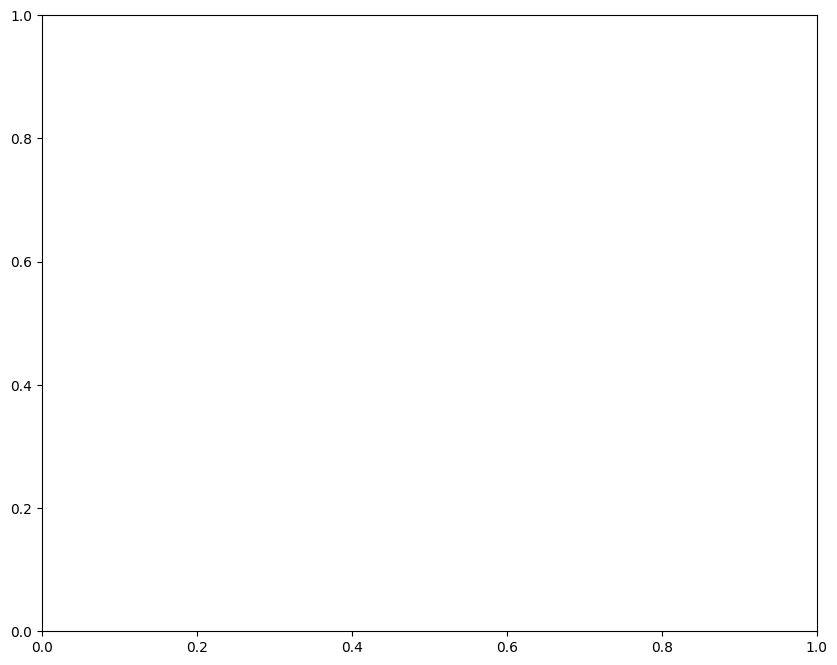

In [12]:
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import os
import subprocess # For running external commands like ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter # Explicitly import FuncAnimation and FFMpegWriter
import random # Import random for sampling

# --- 1. Define the DisjointSetUnion Class (Crucial for Boruvka's) ---
class DisjointSetUnion:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n  # Used for union by rank optimization
        self.num_components = n # Tracks the number of disjoint sets

    def find(self, i):
        """Finds the representative (root) of the set containing element i, with path compression."""
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i]) # Path compression
        return self.parent[i]

    def union(self, i, j):
        """Unites the sets containing elements i and j, with union by rank."""
        root_i = self.find(i)
        root_j = self.find(j)

        if root_i != root_j:
            # Attach smaller rank tree under root of higher rank tree
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            self.num_components -= 1 # One less component after successful union
            return True  # Indicates a successful union (components merged)
        return False # Indicates they were already in the same set


# --- 2. Define your Graph/Network Class ---
class GraphAnalyzer:
    def __init__(self, df):
        """
        Initializes the GraphAnalyzer with a DataFrame containing graph data.
        :param df: Pandas DataFrame with 'source', 'target', and 'weight' columns.
        """
        self.df = df
        self.G = self._build_networkx_graph()
        self.node_to_idx = self._create_node_to_index_map()

    def _build_networkx_graph(self):
        """
        Builds a NetworkX graph from the DataFrame.
        Assumes 'source', 'target', and 'weight' columns.
        """
        G = nx.Graph() # Use nx.Graph for an undirected graph (MST is for undirected)
        for _, row in self.df.iterrows():
            try:
                weight = float(row['weight'])
            except ValueError:
                print(f"Warning: Non-numeric weight found for edge ({row['source']}, {row['target']}). Using weight 1.0.")
                weight = 1.0
            G.add_edge(row['source'], row['target'], weight=weight)
        return G

    def _create_node_to_index_map(self):
        """
        Creates a mapping from NetworkX node identifiers to 0-based integer indices
        for use with the DisjointSetUnion.
        """
        unique_nodes = sorted(self.G.nodes())
        return {node: idx for idx, node in enumerate(unique_nodes)}

    # --- Boruvka's MST Algorithm (MODIFIED to collect edges for `create_animation`) ---
    def boruvka_mst(self, animate=False, video_output_name=None, animation_edge_limit=None):
        """
        Implements Borůvka's algorithm to find the Minimum Spanning Tree.
        Includes optional animation that uses the provided create_animation function.
        :param animation_edge_limit: If not None, creates animation on a sample of the graph using
                                     up to this many edges from the original graph.
        """
        start_time = time.time()

        n = len(self.G.nodes())
        if n == 0:
            return [], 0, 0, [0], [0], [0]

        dsu = DisjointSetUnion(n)
        mst_edges_list = [] # Renamed to avoid conflict with nx.Graph.edges()
        mst_cost = 0.0

        cost_evolution = [0.0]
        edges_count_evolution = [0]
        components_count_evolution = [n]

        # --- Store MST edges collected during the algorithm for animation ---
        # Boruvka's doesn't strictly build by increasing global weight,
        # but this list will store edges added to the MST.
        edges_for_animation = []

        while dsu.num_components > 1:
            component_min_edge = {}

            if not self.G.edges():
                print("Warning: No edges in the graph, cannot form MST.")
                break

            for u_node, v_node, edge_attrs in self.G.edges(data=True):
                weight = edge_attrs['weight']

                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                comp_u_root = dsu.find(u_idx)
                comp_v_root = dsu.find(v_idx)

                if comp_u_root != comp_v_root:
                    if comp_u_root not in component_min_edge or float(weight) < component_min_edge[comp_u_root][0]:
                        component_min_edge[comp_u_root] = (float(weight), u_node, v_node)
                    if comp_v_root not in component_min_edge or float(weight) < component_min_edge[comp_v_root][0]:
                        component_min_edge[comp_v_root] = (float(weight), u_node, v_node)

            if not component_min_edge and dsu.num_components > 1:
                print("Warning: No edges found to connect remaining components. Graph may be disconnected.")
                break

            edges_added_in_phase = False
            # Sort edges for deterministic processing within a phase
            sorted_min_edges = sorted(component_min_edge.values(), key=lambda x: x[0])

            for weight, u_node, v_node in sorted_min_edges:
                u_idx = self.node_to_idx[u_node]
                v_idx = self.node_to_idx[v_node]

                if dsu.union(u_idx, v_idx):
                    mst_edges_list.append((u_node, v_node, weight))
                    mst_cost += weight
                    edges_added_in_phase = True

                    # Add edge to the list for animation
                    edges_for_animation.append((u_node, v_node, {'weight': weight}))

                    cost_evolution.append(mst_cost)
                    edges_count_evolution.append(len(mst_edges_list))
                    components_count_evolution.append(dsu.num_components)

            if not edges_added_in_phase and dsu.num_components > 1:
                print("Warning: Boruvka's algorithm made no progress in a phase but components remain. This indicates a disconnected graph.")
                break

        execution_time = time.time() - start_time

        if animate:
            print(f"\nGenerating MST animation...")
            if not video_output_name:
                video_output_name = "boruvka_mst_animation" # Default name if not provided

            # --- Animation Sampling Logic for G and MST ---
            G_for_animation = nx.Graph() # Initialize an empty graph for animation
            mst_for_animation_graph = nx.Graph() # Initialize an empty graph for animation's MST edges

            if animation_edge_limit is not None and animation_edge_limit > 0:
                print(f"Creating animation using the first {animation_edge_limit} edges of the original graph.")
                all_original_edges_list = list(self.G.edges(data=True)) # Convert to list for slicing

                # Take the first N edges
                sampled_edges_data = all_original_edges_list[:min(animation_edge_limit, len(all_original_edges_list))]

                G_for_animation.add_edges_from(sampled_edges_data)

                # Filter the collected MST edges to only include those present in the sampled graph
                for u, v, attrs in edges_for_animation:
                    # Check if the edge exists in the sampled graph (G_for_animation)
                    if G_for_animation.has_edge(u, v):
                        mst_for_animation_graph.add_edge(u, v, **attrs)

                if not mst_for_animation_graph.edges():
                    print("Warning: The sampled graph has no MST edges from the original MST. Animation might be empty or problematic.")

            else:
                # If no sampling, use the full original graph and the complete MST found
                G_for_animation = self.G # Use the full graph
                for u, v, weight_dict in edges_for_animation:
                    mst_for_animation_graph.add_edge(u, v, weight=weight_dict['weight'])

            # Call the animation function with the (potentially sampled) graphs
            create_animation(G_for_animation, mst_for_animation_graph, video_output_name)
            print(f"MST animation '{video_output_name}.mp4' created.")

        print(f"\n--- Boruvka's MST Results ---")
        print(f"MST Total Cost: {mst_cost:.4f}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print(f"Number of Edges in MST: {len(mst_edges_list)}")
        print(f"Final Number of Components: {dsu.num_components}")

        return mst_edges_list, mst_cost, execution_time, cost_evolution, edges_count_evolution, components_count_evolution

# --- NEW/MODIFIED ANIMATION FUNCTION (`create_animation` based on requirements) ---
def create_animation(G, mst, name):
    """
    Creates an animation of the MST being built, starting with a blank canvas
    and adding 100 MST edges at a time. Only nodes connected by current MST edges
    are shown (lit up).

    Args:
        G (nx.Graph): The graph to draw (this is now potentially a sampled graph).
        mst (nx.Graph): The Minimum Spanning Tree graph (this is now potentially a subset
                        of the MST that falls within the sampled G).
        name (str): The base name for the output video file (e.g., 'my_mst_animation').
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    # Calculate positions once for the entire graph being animated (sampled or full)
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout

    # Get MST edges and sort by weight for animation.
    mst_edges_sorted = list(mst.edges(data=True))
    mst_edges_sorted.sort(key=lambda x: x[2]['weight'])
    total_mst_edges = len(mst_edges_sorted)

    # --- Frame calculation: add 100 edges at a time ---
    frames_edge_counts = []
    current_count = 0
    while current_count < total_mst_edges:
        frames_edge_counts.append(current_count)
        current_count += 100  # Stays at 100 as requested
    frames_edge_counts.append(total_mst_edges) # Ensure the last frame shows all edges

    # Animation function
    def update(frame_idx):
        ax.clear() # Start each frame with a blank canvas

        num_edges_to_show = frames_edge_counts[frame_idx]
        current_mst_edges_data = mst_edges_sorted[:num_edges_to_show]

        # Collect all unique nodes that are part of the current MST edges displayed
        nodes_in_current_mst = set()
        for u, v, _ in current_mst_edges_data:
            nodes_in_current_mst.add(u)
            nodes_in_current_mst.add(v)

        # Draw only nodes that are part of the current MST edges (light up if used)
        if nodes_in_current_mst:
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes_in_current_mst),
                                   node_color='pink', node_size=60, ax=ax) # Increased node_size for visibility

        # Draw the current MST edges in 'midnightblue'
        if current_mst_edges_data:
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(u, v) for u, v, _ in current_mst_edges_data],
                                   edge_color='midnightblue', width=2, ax=ax)

        # Calculate cumulative weight up to the current frame
        cumulative_weight = sum(edge[2]['weight'] for edge in current_mst_edges_data)

        # Update title to show exact edge count and total weight
        ax.set_title(f'MST Building - Edges: {num_edges_to_show}/{total_mst_edges}\nTotal Weight: {cumulative_weight:.2f}')
        ax.axis('off') # Keep axes off for a cleaner graph visualization
        return ax

    # Create animation with specified interval and frames
    # interval=2000 means 2 seconds per frame
    ani = FuncAnimation(fig, update, frames=len(frames_edge_counts), interval=2000, blit=False)

    # Save animation as video
    # fps=0.5 means 0.5 frames per second (1 frame every 2 seconds)
    writer = FFMpegWriter(fps=0.5, metadata=dict(artist='AI'), bitrate=1800)
    ani.save(f'{name}.mp4', writer=writer)

    plt.close(fig) # Close the figure to free memory


# --- Main Execution Block ---
if __name__ == "__main__":
    # Initialize these dictionaries for the dummy graph case, if they aren't global
    nodes_data = {}
    edges_data = {}
    times_data = {}

    # Load the dataset
    try:
        data_df = pd.read_csv('soc-livemocha_cleaned.csv')
    except FileNotFoundError:
        print("Error: 'soc-livemocha_cleaned.csv' not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
        print("Creating a small dummy graph for demonstration.")
        data = {
            'source': [0, 0, 1, 1, 2, 3, 0, 3, 1, 4],
            'target': [1, 2, 2, 3, 3, 4, 3, 5, 4, 5],
            'weight': [10, 15, 20, 25, 30, 5, 12, 8, 18, 7]
        }
        data_df = pd.DataFrame(data)

    # Instantiate the GraphAnalyzer
    analyzer = GraphAnalyzer(data_df)

    print("Running Boruvka's MST algorithm...")

    # --- Call boruvka_mst with animation settings ---
    output_dir = 'boruvka_livemocha_video_output'
    os.makedirs(output_dir, exist_ok=True)
    # Changed video_base_name to reflect it's a sampled animation
    video_base_name = os.path.join(output_dir, 'mst_livemocha_animation_20k_edges')

    results = analyzer.boruvka_mst(
        animate=True,
        video_output_name=video_base_name,
        animation_edge_limit=20000 # Use the first 20,000 edges for animation
    )

    mst_edges, mst_cost, exec_time, cost_evol, edges_evol, components_evol = results

    nodes_data['livemocha'] = len(analyzer.G.nodes())
    edges_data['livemocha'] = len(analyzer.G.edges())
    times_data['livemocha'] = exec_time


    print(f"\nAlgorithm completed. Total execution time (from returned value): {exec_time:.4f} seconds")

    # Example of how you might plot the evolution data (uncomment to run)
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(cost_evol, marker='o', linestyle='-', label='MST Cost')
    # plt.plot(edges_evol, marker='x', linestyle='--', label='Edges in MST')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Value')
    # plt.title('MST Cost and Edges Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(components_evol, marker='s', linestyle='-', color='red', label='Number of Components')
    # plt.xlabel('Phase/Step')
    # plt.ylabel('Count')
    # plt.title('Number of Components Evolution Over Phases')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

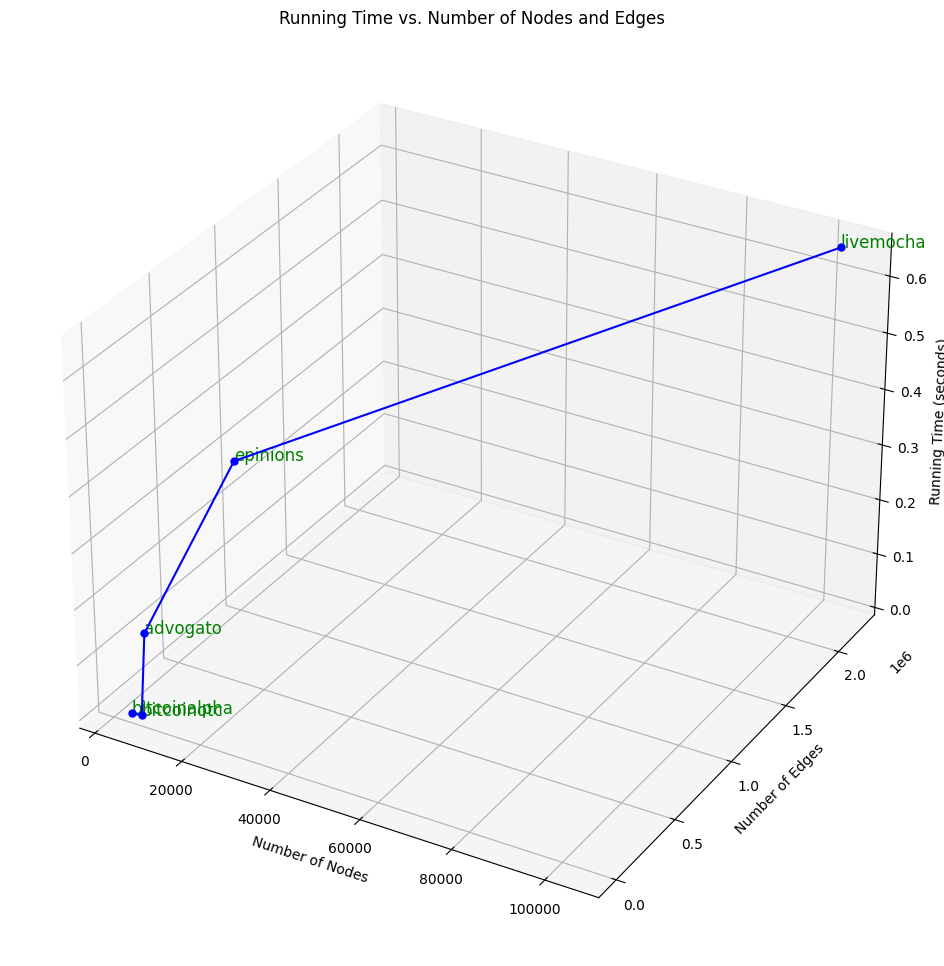

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Get the number of nodes, edges, and running times
nodes_list = list(nodes_data.values())
edges_list = list(edges_data.values())
times_list = list(times_data.values())
labels = list(times_data.keys())

# Create a 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot lines connecting the data points
ax.plot(nodes_list, edges_list, times_list, c='b', marker='o', markersize=5)

# Label the points
for i, label in enumerate(labels):
    ax.text(nodes_list[i], edges_list[i], times_list[i], label, size=12, zorder=1, color='green')

# Set labels and title
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Number of Edges')
ax.set_zlabel('Running Time (seconds)')
ax.set_title('Running Time vs. Number of Nodes and Edges')

plt.show()